## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
'''
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #print(gray.shape)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
with open('obj_pts.p', 'wb') as f:
    pickle.dump(objpoints, f)
with open('img_pts.p', 'wb') as f:   
    pickle.dump(imgpoints, f)

fpath = "../test_images/"
fname = "straight_lines2.jpg"
img = mpimg.imread(fpath+fname)
plt.imshow(img)
print(img.shape)
height = img.shape[0]
width = img.shape[1]
img_size = (width, height)
#using straight_lines2.jpg to get transform matrix of birdview.
src = np.float32([[585,457],[700,457],[1060,690],[260,690]])
dst = np.float32([[300,0],[980,0],[980,height],[300,height]])
M = cv2.getPerspectiveTransform(src, dst)
inverse_M = cv2.getPerspectiveTransform(dst, src)
with open('M.p', 'wb') as f:
    pickle.dump(M, f)
with open('inverseM.p', 'wb') as f:
    pickle.dump(inverse_M, f)
'''

'\nimport numpy as np\nimport pickle\nimport cv2\nimport glob\nimport matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\n%matplotlib inline\n\n# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)\nobjp = np.zeros((6*9,3), np.float32)\nobjp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)\n\n# Arrays to store object points and image points from all the images.\nobjpoints = [] # 3d points in real world space\nimgpoints = [] # 2d points in image plane.\n\n# Make a list of calibration images\nimages = glob.glob(\'../camera_cal/calibration*.jpg\')\n\n# Step through the list and search for chessboard corners\nfor fname in images:\n    img = cv2.imread(fname)\n    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)\n    #print(gray.shape)\n    # Find the chessboard corners\n    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)\n\n    # If found, add object points, image points\n    if ret == True:\n        objpoints.append(objp)\n        imgpoints.append(corners)\nwith open

## And so on and so forth...

In [17]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

with open('obj_pts.p', 'rb') as f:
    objpoints = pickle.load(f)
with open('img_pts.p', 'rb') as f:
    imgpoints =pickle.load(f)
#This cell is to calibrate camera and get undistorted images.
fpath = "../test_images/"
fname = "test5.jpg"
img = mpimg.imread(fpath+fname)
print(img.shape)
height = img.shape[0]
width = img.shape[1]
img_size = (width, height)
#define function calculating camera matrix and distort coefficients. Then using these parameters to get undistort images.
def undistortImage(image, objpts, imgpts):
    ret, cameraMat, distortCoef,rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, (image.shape[1],image.shape[0]), None, None)
    undist_img = cv2.undistort(img, cameraMat, distortCoef, None, cameraMat)
    return undist_img
undist_img = undistortImage(img, objpoints, imgpoints)
gray_img = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
mpimg.imsave("../output_images/undistorted.png", undist_img)
'''
mpimg.imsave(fpath + "undist_" + fname, undist_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)
'''

(720, 1280, 3)


'\nmpimg.imsave(fpath + "undist_" + fname, undist_img)\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))\nax1.imshow(img)\nax1.set_title(\'Original Image\', fontsize=30)\nax2.imshow(undist_img)\nax2.set_title(\'Undistorted Image\', fontsize=30)\n'

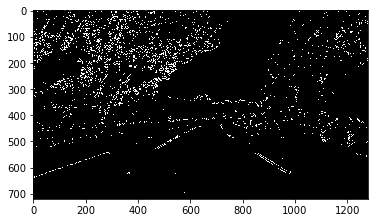

In [2]:
#get X or Y gradient via Sobel Operator.
def get_abs_Sobel_grad(gray_img, sobel_kernel=5, direction = 'X'):
    if direction == 'X':
        sobelx=cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,sobel_kernel)
        return np.absolute(sobelx)
    elif direction =='Y':
        sobely=cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,sobel_kernel)
        return np.absolute(sobely)
    else:
        print('Please set gradient direction parameter: X or Y?')
        return gray_img
abs_sobelx = get_abs_Sobel_grad(gray_img, sobel_kernel=5)
abs_sobely = get_abs_Sobel_grad(gray_img, sobel_kernel=5,direction='Y')


#Scale the gradient image.
def get_scaled_Sobel(abs_sobel_img):
    return np.uint8(255*abs_sobel_img/np.max(abs_sobel_img))
scaled_sobelx = get_scaled_Sobel(abs_sobelx)
scaled_sobely = get_scaled_Sobel(abs_sobely)
#get binary image of gradient.
def binary_Sobel(scaled_img, threshold=(20, 100)):
    binary_sobel = np.zeros_like(scaled_img)
    binary_sobel[(scaled_img>=threshold[0])&(scaled_img<=threshold[1])]=1
    return binary_sobel
binary_sobelx = binary_Sobel(scaled_sobelx)
binary_sobely = binary_Sobel(scaled_sobely)
'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary_sobelx,cmap='gray')
ax1.set_title('Sobel X', fontsize=20)
ax2.imshow(binary_sobely, cmap='gray')
ax2.set_title('Sobel Y', fontsize=20)
'''
binary_Comb_Grad = np.zeros_like(gray_img)
binary_Comb_Grad[(binary_sobelx==1)&(binary_sobely==1)] = 1
plt.imshow(binary_Comb_Grad, cmap='gray')
#get binary image of gradient's magnitude

def binary_Magnitude(abs_sobelx, abs_sobely, threshold=(20, 100)):    
    sobelxy = np.sqrt(np.square(abs_sobelx)+np.square(abs_sobely)) 
    scaled_sobelxy = np.uint8(255*sobelxy/np.max(sobelxy))
    binary_sobelxy = np.zeros_like(scaled_sobelxy)
    binary_sobelxy[(scaled_sobelxy >= threshold[0]) & (scaled_sobelxy <= threshold[1])] = 1
    return binary_sobelxy
binary_mag = binary_Magnitude(abs_sobelx, abs_sobely)
#get binary image of direction of gradient
def binary_Dir_Grad(abs_sobelx, abs_sobely, arc_threshold=(0.7, 1.3)):
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    binary_dir_grad = np.zeros_like(dir_grad)
    binary_dir_grad[(dir_grad>=arc_threshold[0]) & (dir_grad<=arc_threshold[1])] = 1
    return binary_dir_grad
binary_dir_grad = binary_Dir_Grad(np.float32(scaled_sobelx), np.float32(scaled_sobely))
                    
def combine_Binary_Grad(binary_sbx, binary_sby, binary_mag, binary_dir_grad):
    binary_Comb_Grad = np.zeros_like(binary_sbx)
    binary_Comb_Grad[((binary_sbx==1)&(binary_sby==1))|((binary_mag==1)&(binary_dir_grad==1))] = 1
    return binary_Comb_Grad

binary_combine_grad = combine_Binary_Grad(binary_sobelx, binary_sobely, binary_mag, binary_dir_grad)
#f, (ax0, ax5) = plt.subplots(1, 2, figsize=(20,10))
#ax0.imshow(gray_img,cmap='gray')
#ax0.set_title('original grayscale', fontsize=20)
#ax1.imshow(binary_sobelx, cmap='gray')
#ax1.set_title('x direction gradient ', fontsize=20)
#ax2.imshow(binary_sobely, cmap='gray')
#ax2.set_title('y direction gradient', fontsize=20)
#ax3.imshow(binary_mag, cmap='gray')
#ax3.set_title(' magnitude x and y gradient', fontsize=20)
#ax4.imshow(binary_dir_grad, cmap='gray')
#ax4.set_title('direction gradient', fontsize=20)
#ax5.imshow(binary_combine_grad, cmap='gray')
#ax5.set_title('combine img', fontsize=20)

In [6]:
def get_HLS_channel(undist_img, channel='S', threshold=(0,255)):
    HLS_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2HLS)
    if channel=='H':
        H = HLS_img[:,:,0]
        binary_H = np.zeros_like(H)
        binary_H[(H>=threshold[0])&(H<=threshold[1])]=1
        return binary_H
    elif channel=='L':
        L = HLS_img[:,:,1]
        binary_L = np.zeros_like(L)
        binary_L[(L>=threshold[0])&(L<=threshold[1])]=1
        return binary_L
    elif channel=='S':
        S = HLS_img[:,:,2]
        binary_S = np.zeros_like(S)
        binary_S[(S>=threshold[0])&(S<=threshold[1])]=1
        return binary_S
    else:
        print('Please choose one channel parameter of H, L or S?')
        return undist_img
def combine_HS(binary_H, binary_S):
    binary_HS = np.zeros_like(binary_H)
    binary_HS[(binary_H ==1)&(binary_S ==1)] = 1
    return binary_HS
binary_S = get_HLS_channel(undist_img, threshold=(90,255))
binary_H = get_HLS_channel(undist_img, 'H',threshold=(25,40))
#binary_L = get_HLS_channel(undist_img, 'L',threshold=(24,200))
binary_HS = combine_HS(binary_H, binary_S)
#f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
#ax1.imshow(binary_H, cmap='gray')
#ax1.set_title('H channel')
#ax2.imshow(binary_HS, cmap='gray')
#ax2.set_title('H with S channels')
#ax3.imshow(binary_S, cmap='gray')
#ax3.set_title('S channel')

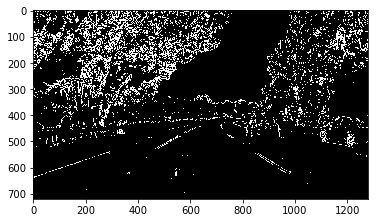

In [7]:
def combine_Binary(binary_color, binary_grad):
    color_grad_comb = np.zeros_like(binary_grad)
    color_grad_comb[(binary_color==1) | (binary_grad==1)]=1
    return color_grad_comb
binary_Combine = combine_Binary(binary_HS, binary_sobelx)    
plt.imshow(binary_Combine, cmap='gray')
mpimg.imsave("../output_images/binary_combo_example.png", binary_Combine)

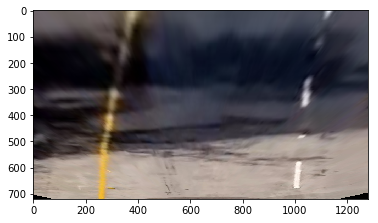

In [9]:
with open("M.p", "rb") as f:
    M = pickle.load(f)
warped_img = cv2.warpPerspective(undist_img, M, img_size)
plt.imshow(warped_img)
mpimg.imsave("../output_images/warped_straight_line.png", warped_img)

In [18]:
"""
#This cell is for transforming all test images to warped ones.
test_images = glob.glob("../test_images/undist_test*.jpg")
i = 1
for fname in test_images:
    undist_img = mpimg.imread(fname)
    warped_img = cv2.warpPerspective(undist_img, M, img_size)
    #plt.imshow(warped_img)
    mpimg.imsave("../test_images/warped_test"+str(i)+".jpg", warped_img)
    i = i+1
"""

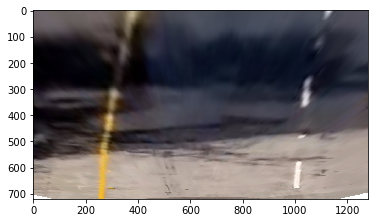

In [10]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#Read a warped_img
warped_img = mpimg.imread("../test_images/warped_test5.jpg")
plt.imshow(warped_img)

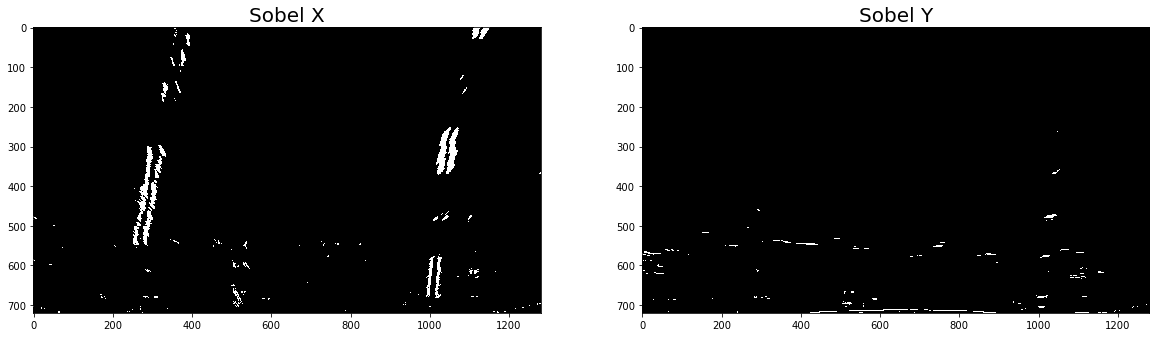

In [11]:
gray_warped = cv2.cvtColor(warped_img, cv2.COLOR_RGB2GRAY)
warped_sobelx = get_abs_Sobel_grad(gray_warped, sobel_kernel=5, direction = 'X')
warped_sobely = get_abs_Sobel_grad(gray_warped, sobel_kernel=5, direction = 'Y')
scaled_warped_sobelx = get_scaled_Sobel(warped_sobelx)
scaled_warped_sobely = get_scaled_Sobel(warped_sobely)

binary_warped_sobelx = binary_Sobel(scaled_warped_sobelx, threshold=(20, 100))
binary_warped_sobely = binary_Sobel(scaled_warped_sobely, threshold=(30, 100))
binary_mag = binary_Magnitude(warped_sobelx, warped_sobely, threshold=(40, 144))
binary_dir_grad = binary_Dir_Grad(warped_sobelx, warped_sobely, arc_threshold=(0.8, np.pi/2))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary_warped_sobelx, cmap='gray')
ax1.set_title('Sobel X', fontsize=20)
ax2.imshow(binary_warped_sobely, cmap='gray')
ax2.set_title('Sobel Y', fontsize=20)

binary_grad = combine_Binary_Grad(binary_warped_sobelx, binary_warped_sobely, binary_mag, binary_dir_grad)
#plt.imshow(binary_grad, cmap='gray')

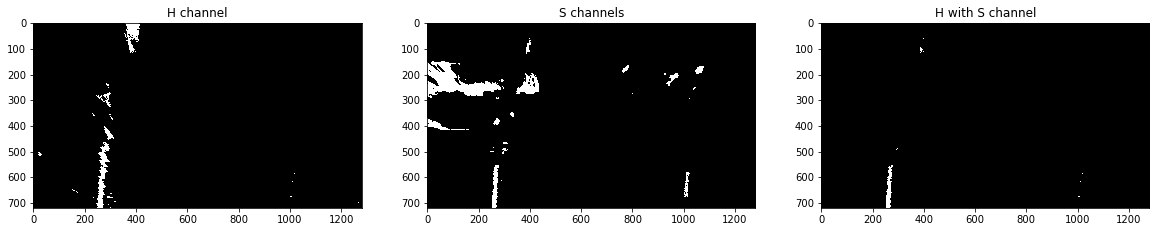

In [12]:
binary_S = get_HLS_channel(warped_img, threshold=(170,255))
binary_H = get_HLS_channel(warped_img, 'H',threshold=(70,100))
binary_L = get_HLS_channel(warped_img, 'L',threshold=(24,200))
#binary_HS = combine_HS(binary_H, binary_S)
binary_HS = np.zeros_like(binary_H)
binary_HS[(binary_H ==1)&(binary_S ==1)] = 1
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(binary_H, cmap='gray')
ax1.set_title('H channel')
ax2.imshow(binary_S, cmap='gray')
ax2.set_title('S channels')
ax3.imshow(binary_HS, cmap='gray')
ax3.set_title('H with S channel')

(720, 1280)


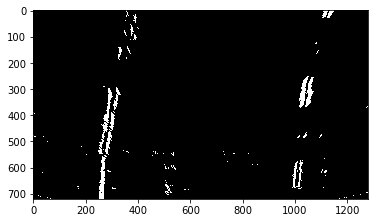

In [13]:
binary_Combine = combine_Binary(binary_HS, binary_warped_sobelx)    
plt.imshow(binary_Combine, cmap='gray')
print(binary_Combine.shape)

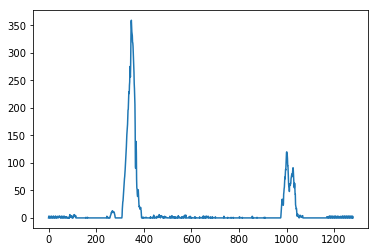

In [113]:
mid_height = np.int(binary_Combine.shape[0]/2)
histogram = np.sum(binary_Combine[mid_height:,:],axis=0)
plt.plot(histogram)

The middle point of image:640
Max value at x-269 left part.
Max value at x-1020 right part.


(720, 0)

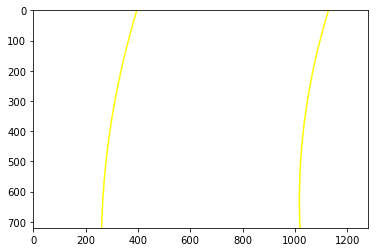

In [14]:
#This function calculates points of lanes for fitting curve.
def calc_Lane_Points(binary_Combine):
    mid_height = np.int(binary_Combine.shape[0]/2)
    histogram = np.sum(binary_Combine[mid_height:,:],axis=0)
    mid_width = np.int(histogram.shape[0]/2)
    print("The middle point of image:{}".format(mid_width))
    leftx_base = np.argmax(histogram[:mid_width])
    rightx_base = np.argmax(histogram[mid_width:]) + mid_width
    print("Max value at x-{} left part.".format(leftx_base))
    print("Max value at x-{} right part.".format(rightx_base))
    nonzero = np.nonzero(binary_Combine)
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    nwindows = 9
    height = binary_Combine.shape[0]
    win_height = np.int(binary_Combine.shape[0]/nwindows)
    margin = 100
    minpixel = 50
    #These two empty lists store indexes of nonzero pixels in nonzerox and nonzeroy.
    left_lane_index = []
    right_lane_index = []
    leftx_current = leftx_base
    rightx_current = rightx_base
    for window in range(nwindows):
        win_y_low = height - (window+1)*win_height
        win_y_high = height - window*win_height
        win_leftx_left = leftx_current - margin
        win_leftx_right = leftx_current + margin
        win_rightx_left = rightx_current - margin
        win_rightx_right = rightx_current + margin
        good_left_ind=((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_leftx_left)&(nonzerox<win_leftx_right)).nonzero()[0]
        good_right_ind=((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_rightx_left)&(nonzerox<win_rightx_right)).nonzero()[0]
        left_lane_index.append(good_left_ind)
        right_lane_index.append(good_right_ind)
        if len(good_left_ind) > minpixel:
            leftx_current = np.int(np.mean(nonzerox[good_left_ind]))
        if len(good_right_ind) > minpixel:
            rightx_current = np.int(np.mean(nonzerox[good_right_ind]))
    left_lane_index = np.concatenate(left_lane_index)
    right_lane_index = np.concatenate(right_lane_index)

    leftx = nonzerox[left_lane_index]
    lefty = nonzeroy[left_lane_index] 
    rightx = nonzerox[right_lane_index]
    righty = nonzeroy[right_lane_index]
    return leftx, lefty, rightx, righty
leftx, lefty, rightx, righty = calc_Lane_Points(binary_Combine)
#This function gets left and right lanes via A*y*y+B*y+C which returns A, B and C coefficients.
def fit_Lanes(leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit
left_fit, right_fit =fit_Lanes(leftx, lefty, rightx, righty)
#This function calculates the whole lanes using fit coefficients A, B, C
def calc_X(binary_Combine, left_fit, right_fit):
    ploty = np.linspace(0, binary_Combine.shape[0]-1, binary_Combine.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx
left_fitx, right_fitx = calc_X(binary_Combine, left_fit, right_fit)

ploty = np.linspace(0, binary_Combine.shape[0]-1, binary_Combine.shape[0] )
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

The middle point of image:640
Max value at x-269 left part.
Max value at x-1020 right part.


(720, 0)

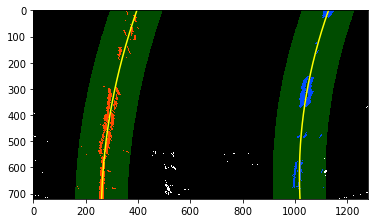

In [15]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_Combine, binary_Combine, binary_Combine))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
leftx, lefty, rightx, righty = calc_Lane_Points(binary_Combine)
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
margin = 100
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [22]:
y_eval = np.max(ploty)
def calc_Curverad(left_fit, right_fit, y_eval)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

1906.66559935 1079.86672007


In [23]:
# Define conversions in x and y from pixels space to meters
def converse_CurveradToMeter(left_fitx, right_fitx, ym_per_pix=30/720, xm_per_pix=3.7/700)
    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

626.216262505 m 339.177742464 m


In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
with open('obj_pts.p', 'rb') as f:
    objpoints = pickle.load(f)
with open('img_pts.p', 'rb') as f:
    imgpoints =pickle.load(f)
with open("M.p", "rb") as f:
    M = pickle.load(f)
with open("inverseM.p", "rb") as f:
    inverseM = pickle.load(f)

The middle point of image:640
Max value at x-268 left part.
Max value at x-1022 right part.


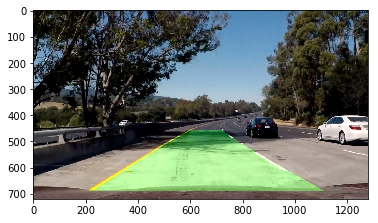

In [18]:
def process_image(img, First_Frame = True):
    undist = undistortImage(img, objpoints, imgpoints)
    warped_img = cv2.warpPerspective(img, M, (1280, 720))
    gray_warped = cv2.cvtColor(warped_img, cv2.COLOR_RGB2GRAY)
    warped_sobelx = get_abs_Sobel_grad(gray_warped, sobel_kernel=5, direction = 'X')
    warped_sobely = get_abs_Sobel_grad(gray_warped, sobel_kernel=5, direction = 'Y')
    scaled_warped_sobelx = get_scaled_Sobel(warped_sobelx)
    scaled_warped_sobely = get_scaled_Sobel(warped_sobely)

    binary_warped_sobelx = binary_Sobel(scaled_warped_sobelx, threshold=(20, 100))
    binary_warped_sobely = binary_Sobel(scaled_warped_sobely, threshold=(20, 100))
    #binary_mag = binary_Magnitude(warped_sobelx, warped_sobely, threshold=(28, 141))
    #binary_dir_grad = binary_Dir_Grad(warped_sobelx, warped_sobely, arc_threshold=(1.0, np.pi/2))

    #binary_grad = combine_Binary_Grad(binary_warped_sobelx, binary_warped_sobely, binary_mag, binary_dir_grad)
    
    binary_S = get_HLS_channel(warped_img, threshold=(170,255))
    binary_H = get_HLS_channel(warped_img, 'H',threshold=(70,100))
    #binary_L = get_HLS_channel(warped_img, 'L',threshold=(24,200))
    binary_HS = combine_HS(binary_H, binary_S)
    
    binary_Combine = combine_Binary(binary_HS, binary_warped_sobelx)
    
    if First_Frame:
        #detected pixels on lanes
        leftx, lefty, rightx, righty = calc_Lane_Points(binary_Combine)
        First_Frame = False
    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each.calculates coefficients
    left_fit, right_fit = fit_Lanes(leftx, lefty, rightx, righty)
    #calculate x position of lanes via coefficients
    left_fitx, right_fitx = calc_X(binary_Combine, left_fit, right_fit)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_Combine).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_Combine.shape[0]-1, binary_Combine.shape[0])
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverseM, (1280, 720)) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result
    #converse the curve unit from Rad to Meter.
    #y_eval = np.max(ploty)
    #left_curverad, right_curverad = converse_CurveradToMeter(left_fitx, right_fitx, ym_per_pix=30/720, xm_per_pix=3.7/700)
result = process_image(img)
plt.imshow(result)
mpimg.imsave("../output_images/example_output.png",result)